# Feature Learning with K-means clustering, Nearest Neighbours, and Bag of Words.

In the previous Practical (PR1) we introduced the task of text/non-text classification. We have seen how training a Logistic Regression classifier using the images' raw pixels was not a good idea and we end up using a simple feature representation consisting in a histogram of the image's grey values.

In this practical we are going to improve the discrimination power of our classifier by learning a Bag of Words (BoW) representation. 

The roadmap is as follows:

* Import train/test data (raw image pixels). We use the same dataset as in PR1, raw_pixels_dataset_5980.pklz
* Extract small image patches from your training set
* Use K-Means to learn a vocabulary of Visual Words
* Represent the train images as BoW histograms and train the Logistic Regression classifier.
* Represent the test images as BoW histograms and evaluate results

### Usupervised Learning of Visual Words

Train_images shape (11960L, 1024L)
Test_images shape  (10396L, 1024L)


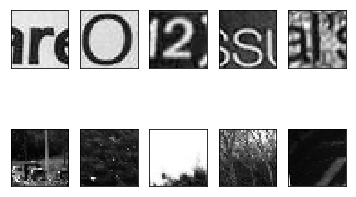

In [1]:
# Read the Dataset (Raw Pixels data). Use same dataset as in Project_PR1.
import pickle
import gzip
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

with gzip.open('../raw_pixels_dataset_5980.pklz','rb') as f:
  (train_labels,train_images,test_labels,test_images) = pickle.load(f)

print("Train_images shape " + str(train_images.shape))
print("Test_images shape  " + str(test_images.shape))

# Show a few samples of the positive and negative classes.
num_text = sum(train_labels==0)
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(2, 5, i)
    ax.imshow(np.reshape(train_images[np.random.randint(0,num_text),:],[32,32]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = fig.add_subplot(2, 5, i+5)
    ax.imshow(np.reshape(train_images[np.random.randint(num_text,train_labels.shape[0]),:],[32,32]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


Images shape (11960L, 32L, 32L)
Patches shape (191360L, 64L)


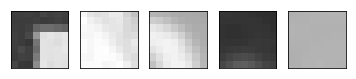

In [2]:
# Extract patches (of 8x8 pixels) from train images
import numpy as np

images = train_images.reshape((-1,32,32)).astype('float32')/255 # reshape images to 32x32
                                                                # and scale values to (0., 1.)
print("Images shape " + str(images.shape))

# Collect image patches with sliding window (8x8) in each train image sample
PATCH_SIZE=8;
STEP_SIZE =8;

patches = np.zeros((0,PATCH_SIZE,PATCH_SIZE))

for x in range(0, 32-PATCH_SIZE+1, STEP_SIZE):
    for y in range(0, 32-PATCH_SIZE+1, STEP_SIZE):
        patches = np.concatenate((patches, images[:,x:x+PATCH_SIZE,y:y+PATCH_SIZE]), axis=0)

patches = patches.reshape((patches.shape[0],-1))
print("Patches shape " + str(patches.shape))

# Visualize a few patches
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(np.reshape(patches[i],[PATCH_SIZE,PATCH_SIZE]), cmap=plt.cm.gray, vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Now we contrast normalize our patches in order to gain illumination invariance. Each patch is normalized by pixel-wise subtracting its mean and dividing by its standard deviation.

D:\Users\byron\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in divide


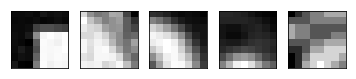

In [3]:
# PreProcessing (I) Contrast Normalization of Patches

mu = patches.mean(axis=1) # mean values
sigma = patches.std(axis=1) + np.ptp(patches, axis=1)/20.0 # standard deviation (plus a small value)

patches = (patches-mu.reshape([-1,1]))/(sigma.reshape([-1,1])) # subtract the mean and divide by std

# Set NaN values (if exist) to 0
w = np.isnan(patches);
patches[w] = 0;

# Visualize a few Constrast Normalized patches
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(np.reshape(patches[i],[PATCH_SIZE,PATCH_SIZE]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Next we perform ZCA whitening of the patches. 

We know how to use PCA to reduce the dimensionality of the data. ZCA whitening is a closely related preprocessing step. 

When we are working with images the raw input is redundant, because the values of adjacent pixels in an image are highly correlated. The goal of whitening is to decorrelate pixel values with each other and make them all have the same variance.

ZCA whitening is implemented as follows:

* First, subtract the mean value of each pixel in image patches to make our data zero-mean.
* Then, as in PCA, compute the eigenvectors of the patches' covariance matrix $\Sigma$.
* The ZCA whitened data is then : 

       $x_{ZCAwhite} = U * diag(1./\sqrt{diag(S) + \epsilon)} * U' * x$

where $U$ contains the eigenvectors of $\Sigma$, $S$ contains the corresponding eigenvalues, $\epsilon$ is a trivial small value and $x$ is the input data (image patches).

More info: http://ufldl.stanford.edu/wiki/index.php/Whitening

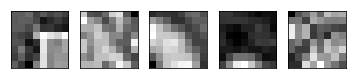

In [4]:
# PreProcessing (II) ZCA Whitening of normalized patches

eig_values, eig_vec = np.linalg.eig(np.cov(patches.T))
epsilon = 0.01
pca = eig_vec.dot(np.diag((eig_values+epsilon)**-0.5).dot(eig_vec.T))


M =  patches.mean(axis=0)
patches = patches -  M # subtract average value
patches = np.dot(patches, pca) # perform pca whitening


# Visualize a few PreProcessed patches
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(np.reshape(patches[i],[PATCH_SIZE,PATCH_SIZE]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Once we have our preprocessed training patches we can perform Unsupervised Learning analysis (K-means clustering) to learn the K visual Words vocabulary.  Then we'll use these vocabulary to represent an image as an histogram of the occurrences of its Words.

In [5]:
# K-means clustering to learn K visual_words from data
from sklearn.cluster import KMeans

NUM_VISUAL_WORDS = 64

km = KMeans(n_clusters=NUM_VISUAL_WORDS, max_iter=50, n_init=1, verbose=False)
km.fit(patches)

visual_words = km.cluster_centers_
print("Visual_words shape " + str(visual_words.shape))

Visual_words shape (64L, 64L)


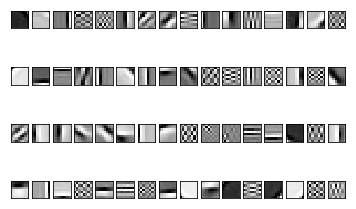

In [6]:
# Visualize the learned vocabulary of Visual Words

from matplotlib import pyplot as plt
import matplotlib.cm as cm
#%pylab inline

fig = plt.figure()
num_col = int(np.ceil(float(NUM_VISUAL_WORDS)/4))
for i in xrange(NUM_VISUAL_WORDS):
    ax = fig.add_subplot(4, num_col, i+1)
    visual_word_ = visual_words[i,:]
    visual_word_ = visual_word_.reshape(PATCH_SIZE,PATCH_SIZE);
    ax.imshow(visual_word_, interpolation='none', cmap = cm.Greys_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Extract Image features using Bag of Words

A Bag of Visual Words is a histogram of occurrence counts of the vocabulary words.

In our case we have 64 Words in the vocabulary, hence the histogram will have 64 bins. 

To represent an image we'll extract image patches, preprocess them, and find its Nearest Neighbor Word in the vocabulary. Finally, each Nearest Neighbor found increments in 1 unit the value of its respective bin in the BoW histogram. 

In [7]:
# Learn a KNN classifier, Each visual Word represents one class
# In this case KNN is used simply as a way to search of the nearest neighbor Visual Word 
# in our vocabulary.
from sklearn.neighbors import KNeighborsClassifier

neig = KNeighborsClassifier(n_neighbors=1)
neig.fit(visual_words,range(0,NUM_VISUAL_WORDS));

In [8]:
# Extract features from train images
train_features = np.zeros((images.shape[0],visual_words.shape[0]));

for i in range(0,images.shape[0]): # for each image

  # Do sliding window (8x8) in each image to extract patches
  #    then normalize, whiten and build the Bag of Words histogram
  for x in range(0,32-PATCH_SIZE+1,STEP_SIZE):
    for y in range(0,32-PATCH_SIZE+1,STEP_SIZE):
        patch = images[i,x:x+PATCH_SIZE,y:y+PATCH_SIZE]
        patch = patch.reshape((1,-1))
        # PreProcessing (I): Normalize
        mu = patch.mean(axis=1) # mean values
        sigma = patch.std(axis=1) + max(np.ptp(patch, axis=1)/20.0, 0.0001) # standard deviation 
                                                               # (plus a small value)
        patch = (patch-(mu[np.newaxis,:]).T)/(sigma[np.newaxis,:]).T
        # Set NaN values to 0
        w = np.isnan(patch);
        patch[w] = 0;
        
        # PreProcessing (II): ZCA whitening
        patch = patch - M # subtract average value
        patch = np.dot(patch, pca) # perform pca whitening
        
        # BoW
        nn = neig.predict(patch)
        train_features[i,nn] = train_features[i,nn] + 1;
        
  train_features[i,:] = train_features[i,:]/max(train_features[i,:]) # Histogram normalization

In [9]:
# If you want to save your training features
import pickle
import gzip

with gzip.open('./BoW_train_features.pklz','wb') as f:
    pickle.dump((train_labels,train_features),f,pickle.HIGHEST_PROTOCOL)

In [10]:
# Extract features from test images
images = test_images.reshape((-1,32,32)).astype('float32')/255
test_features = np.zeros((images.shape[0],visual_words.shape[0]));

for i in range(0,images.shape[0]): #for each image
    
  # Do sliding window (8x8) in each image to extract patches
  #    then normalize, whiten and build the Bag of Words histogram
  for x in range(0,32-PATCH_SIZE+1,STEP_SIZE):
    for y in range(0,32-PATCH_SIZE+1,STEP_SIZE):
        patch = images[i,x:x+PATCH_SIZE,y:y+PATCH_SIZE]
        patch = patch.reshape((1,-1))
        # PreProcessing (I): Normalize
        mu = patch.mean(axis=1) # mean values
        sigma = patch.std(axis=1) + max(np.ptp(patch, axis=1)/20.0, 0.0001) # standard deviation 
                                                               # (plus a small value)
        patch = (patch-(mu[np.newaxis,:]).T)/(sigma[np.newaxis,:]).T
        # Set NaN values to 0
        w = np.isnan(patch);
        patch[w] = 0;
        
        # PreProcessing (II): ZCA whitening
        patch = patch - M # subtract average value
        patch = np.dot(patch, pca) # perform pca whitening

        # BoW
        nn = neig.predict(patch)
        test_features[i,nn] = test_features[i,nn] + 1;
        
  test_features[i,:] = test_features[i,:]/max(test_features[i,:])  # Histogram normalization

In [11]:
# If you want to save your test features
import pickle
import gzip

with gzip.open('./BoW_test_features.pklz','wb') as f:
    pickle.dump((test_labels,test_features),f,pickle.HIGHEST_PROTOCOL)

## <font color='red'>Exercise 1: Logistic Regression classification with BoW features.</font>

<font color='blue'>Train a Logistic Regression classifier with the learned BoW features. Use your Logistic Regression and Gradient Descent code from Project_PR1. Explain how you have set the parameters of the Gradient Descent algorithm.</font>

The first part of the code is just the libraries needed and the functions that were created in the first practice.

In [13]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline


# Function (modules) declarations
def sigmoid(X):
    """Return the Sigmoid of X.

    Computes the Sigmoid function of the input argument X.
    """
    return 1.0 / (1 + np.exp(-X))


def GradientDescent(x, y, max_iterations=2500, alpha=0.1):
    """Return theta."""
    m, n = x.shape  # number of samples, number of features

    # y must be a column vector
    y = y.reshape(m, 1)

    # initialize the parameters
    theta = np.ones(shape=(n, 1))

    # Repeat until convergence (or max_iterations)
    for iteration in range(max_iterations):
        h = sigmoid(np.dot(x, theta))
        error = (h-y)
        gradient = np.dot(x.T, error) / m
        theta = theta - alpha*gradient

    return theta


def classifyVector(X, theta, probability):
    """Return predicted label of X.

    Evaluate the Logistic Regression model h(x) with theta parameters,
    and returns the predicted label of x.
    """
    prob = sigmoid(sum(np.dot(X, theta)))
    if prob > probability:
        return 1.0
    else:
        return 0.0

The following code adapts the logistic regression classifier by sending to it the new images and features (BoW) created in the preliminary part of this notebook.

In [14]:
# Import the train/test data (raw image pixels).
with gzip.open('./BoW_train_features.pklz', 'rb') as f:
    (prepro_train_labels, prepro_train_images) = pickle.load(f)

with gzip.open('./BoW_test_features.pklz', 'rb') as f:
    (prepro_test_labels, prepro_test_images) = pickle.load(f)

print("Preprocessed train images shape = " + str(prepro_train_images.shape))
print("Preprocessed test images shape = " + str(prepro_test_images.shape))

# Logistic Regression gradient descent optimization
w_bow = GradientDescent(prepro_train_images, prepro_train_labels)

H_bowTr = ([
    classifyVector(prepro_train_images[i, :], w_bow, 0.5)
    for i in range(prepro_train_images.shape[0])])

# Calculate classification Accuracy in test data
H_bowTe = ([
    classifyVector(prepro_test_images[i, :], w_bow, 0.5)
    for i in range(prepro_test_images.shape[0])])

# confusion matrix on test data
cm_bow = confusion_matrix(prepro_test_labels, H_bowTe)
print 'BoW Confusion matrix:'
print (cm_bow)

Preprocessed train images shape = (11960L, 64L)
Preprocessed test images shape = (10396L, 64L)
BoW Confusion matrix:
[[4002 1196]
 [1164 4034]]


<font color='blue'>Compare the Test Accuracy, Precision, and Recall with the obtained in Practical_PR1 with the histograms of grey values. Show the confusion matrices and Precision/Recall curves.</font>

The first part of the code produces the results found in the previous practice.

In [15]:
# Import the train/test data (raw image pixels).
with gzip.open('../raw_pixels_dataset_5980.pklz', 'rb') as f:
    (train_labels, train_images, test_labels, test_images) = pickle.load(f)

print("train_images shape" + str(train_images.shape))
print("test_images shape" + str(test_images.shape))

# For each example we compute the histogram of grey intensity values
old_train_images = np.zeros([train_images.shape[0], 8])
for i in range(train_images.shape[0]):
    # Count how many values are in a range
    old_train_images[i, :] = np.histogram(train_images[i, :], 8)[0]
    # Histogram normalization
    old_train_images[i, :] /= np.sum(old_train_images[i, :])

old_test_images = np.zeros([test_images.shape[0], 8])
for i in range(test_images.shape[0]):
    old_test_images[i, :] = np.histogram(test_images[i, :], 8)[0]
    # Histogram normalization
    old_test_images[i, :] /= np.sum(old_test_images[i, :])

print "old_train_images shape" + str(old_train_images.shape)
print "old_test_images shape" + str(old_test_images.shape)

# Logistic Regression gradient descent optimization
w1 = GradientDescent(old_train_images, train_labels)

H_train = ([
    classifyVector(old_train_images[i, :], w1, 0.5)
    for i in range(old_train_images.shape[0])])

# Calculate classification Accuracy in test data
H_test = ([
    classifyVector(old_test_images[i, :], w1, 0.5)
    for i in range(old_test_images.shape[0])])

# confusion matrix on test data
cm = confusion_matrix(test_labels, H_test)
print 'Previous Confusion matrix:'
print (cm)

train_images shape(11960L, 1024L)
test_images shape(10396L, 1024L)
old_train_images shape(11960L, 8L)
old_test_images shape(10396L, 8L)
Previous Confusion matrix:
[[3664 1534]
 [1172 4026]]


The following code calculate the accuracy values.

In [16]:
print "BoW Train Accuracy:", (str(float(
    np.sum(H_bowTr == prepro_train_labels)) / prepro_train_labels.shape[0]))
print "BoW Test Accuracy : ", (str(float(
    np.sum(H_bowTe == prepro_test_labels)) / prepro_test_labels.shape[0]))

print "Previous Train Accuracy :", (
    str(float(np.sum(H_train == train_labels)) / train_labels.shape[0]))
print "Previous Test Accuracy : ", (
    str(float(np.sum(H_test == test_labels)) / test_labels.shape[0]))

BoW Train Accuracy: 0.869481605351
BoW Test Accuracy :  0.772989611389
Previous Train Accuracy : 0.720819397993
Previous Test Accuracy :  0.739707579838


The following code plots the confusion matrices using the BoW and the previous data.

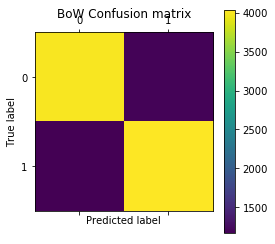

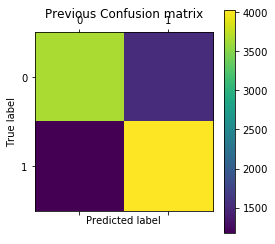

In [17]:
# Plot BoW confusion matrix
plt.matshow(cm_bow)
plt.title('BoW Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot confusion matrix
plt.matshow(cm)
plt.title('Previous Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The following code calculates the precision and the recall using the BoW and the previous data.

In [18]:
# BoW Precision
bow_precision = float(cm_bow[1, 1]) / float((cm_bow[1, 1] + cm_bow[0, 1]))
print "BoW Precision:", bow_precision

# BoW Recall
bow_recall = float(cm_bow[1, 1]) / float((cm_bow[1, 0] + cm_bow[1, 1]))
print "BoW Recall:", bow_recall

# Precision
precision = float(cm[1, 1]) / float((cm[1, 1] + cm[0, 1]))
print "Previous Precision:", precision

# Recall
recall = float(cm[1, 1]) / float((cm[1, 0] + cm[1, 1]))
print "Previous Recall:", recall

BoW Precision: 0.771319311663
BoW Recall: 0.776067718353
Previous Precision: 0.724100719424
Previous Recall: 0.774528664871


<font color='blue'>Analyze the effect of PreProcessing the image patches. Show test Accuracy w./w.o. Contrast Normalization / PCA whitening. Visualize the vocabularies of learned Visual Words. Comment the results.</font>

The first thing to do is produce a new set of data without preprocessing.

train_img before reshape(11960L, 1024L)
test_img before reshape(10396L, 1024L)
train_img shape (11960L, 32L, 32L)
test_img shape (10396L, 32L, 32L)
train_patches shape (191360L, 64L)
test_patches shape (166336L, 64L)
visual_words shape (64L, 64L)


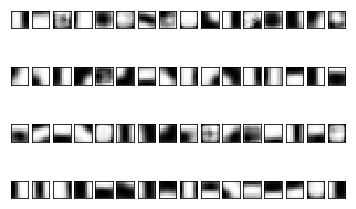

In [3]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline


# Import the train/test data (raw image pixels).
with gzip.open('../raw_pixels_dataset_5980.pklz', 'rb') as f:
    (train_labels, train_img, test_labels, test_img) = pickle.load(f)

print("train_img before reshape" + str(train_img.shape))
print("test_img before reshape" + str(test_img.shape))

# -----------------------------------------------------------------
# Extract patches (of 8x8 pixels) from train images and test images

# reshape images to 32x32 and scale values to (0, 1)
train_img = train_img.reshape((-1, 32, 32)).astype('float32') / 255
test_img = test_img.reshape((-1, 32, 32)).astype('float32') / 255

print("train_img shape " + str(train_img.shape))
print("test_img shape " + str(test_img.shape))

# Collect image patches with sliding window (8x8) in each train image sample
PATCH_SIZE = 8
STEP_SIZE = 8

# Create a container for the patches
# 0 = initialization of container   <- This value is going to be updated to the
#                                      number of images of the training set.
# PATCH_SIZE = 8 = x (width) dimensions of the image
# PATCH_SIZE = 8 = y (height) dimensions of the image
# As a result, in this case, the resolution of the patch is 8 x 8 = 64 px
train_patches = np.zeros((0, PATCH_SIZE, PATCH_SIZE))
test_patches = np.zeros((0, PATCH_SIZE, PATCH_SIZE))

# Sliding window process
for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
    for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        train_patches = (
            np.concatenate(  # increase the container each iteration
                (train_patches,
                 train_img[:, x: x + PATCH_SIZE, y: y + PATCH_SIZE]),
                axis=0))
        test_patches = (
            np.concatenate(  # increase the container each iteration
                (test_patches,
                 test_img[:, x: x + PATCH_SIZE, y: y + PATCH_SIZE]),
                axis=0))

# Store the patch as a vector
train_patches = train_patches.reshape((train_patches.shape[0], -1))
test_patches = test_patches.reshape((test_patches.shape[0], -1))
print("train_patches shape " + str(train_patches.shape))
print("test_patches shape " + str(test_patches.shape))

# ----------------------------------------------------
# K-means clustering to learn K visual_words from data
NUM_VISUAL_WORDS = 64

km = KMeans(n_clusters=NUM_VISUAL_WORDS, max_iter=50, n_init=1, verbose=False)
km.fit(train_patches)

visual_words = km.cluster_centers_
print("visual_words shape " + str(visual_words.shape))

# Visualize the learned vocabulary of visual words
fig = plt.figure()
num_col = int(np.ceil(NUM_VISUAL_WORDS / 4.0))  # Round up to higher
for i in xrange(NUM_VISUAL_WORDS):
    ax = fig.add_subplot(4, num_col, i+1)
    visual_word_ = visual_words[i, :]
    visual_word_ = visual_word_.reshape(PATCH_SIZE, PATCH_SIZE)
    ax.imshow(visual_word_, interpolation='none', cmap=cm.Greys_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The resulting visual words from the unprocessed patches seem blurry and not so different between each other, while the vocabulary of learned words for the preprocessed patches seems to have more detailed visual words. More detailed visual words will decrease the uncertainty of clustering test images, but this seems harder for the unprocessed visual words.

The following code will take some time to complete but once completed, it stores the data in a file so that it doesn't have to be executed everytime.

In [ ]:
# -------------------------------------------------------------
# Learn a KNN classifier, each visual word represents one class
# In this case KNN is used simply as a way to search the nearest neighbor
# visual word in our vocabulary

neig = KNeighborsClassifier(n_neighbors=1)
neig.fit(visual_words, range(0, NUM_VISUAL_WORDS))

# Extract features from train and test images
train_features = np.zeros((train_img.shape[0], visual_words.shape[0]))
test_features = np.zeros((test_img.shape[0], visual_words.shape[0]))

for i in range(0, train_img.shape[0]):  # for each train image
    # Do sliding window (8x8) in each image to extract patches and build the
    # Bag of Words histogram
    for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
            train_patches = train_img[i, x: x + PATCH_SIZE, y: y + PATCH_SIZE]
            train_patches = train_patches.reshape(1, -1)

            # # Set NaN values to 0
            # w = np.isnan(train_patches)
            # train_patches[w] = 0

            # BoW
            nn = neig.predict(train_patches)
            train_features[i, nn] = train_features[i, nn] + 1

    # Histogram Normalization
    train_features[i, :] = train_features[i, :] / max(train_features[i, :])

for i in range(0, test_img.shape[0]):  # for each test image
    # Do sliding window (8x8) in each image to extract patches and build the
    # Bag of Words histogram
    for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
            test_patches = test_img[i, x: x + PATCH_SIZE, y: y + PATCH_SIZE]
            test_patches = test_patches.reshape(1, -1)

            # # Set NaN values to 0
            # w = np.isnan(train_patches)
            # train_patches[w] = 0

            # BoW
            nn = neig.predict(test_patches)
            test_features[i, nn] = test_features[i, nn] + 1

    # Histogram Normalization
    test_features[i, :] = test_features[i, :] / max(test_features[i, :])

# Save your test features
with gzip.open('./BoW-no_preprocess.pklz', 'wb') as f:
    pickle.dump(
        (train_labels, train_features, test_labels, test_features),
        f, pickle.HIGHEST_PROTOCOL)

Then we perform the same steps as for the BoW with the processed images.

Unprocessed train images shape = (11960L, 64L)
Unprocessed test images shape = (10396L, 64L)
Unprocessed BoW Confusion matrix:
[[4353  845]
 [1677 3521]]
Unprocessed BoW Train Accuracy: 0.808026755853
Unprocessed BoW Test Accuracy :  0.757406694883


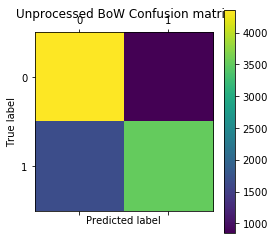

Unprocessed BoW Precision: 0.806459001374
Unprocessed BoW Recall: 0.677375913813


In [21]:
# Import the train/test data (raw image pixels).
with gzip.open('./BoW-no_preprocess.pklz', 'rb') as f:
    (train_labels, train_images, test_labels, test_images) = pickle.load(f)

print("Unprocessed train images shape = " + str(train_images.shape))
print("Unprocessed test images shape = " + str(test_images.shape))

# Logistic Regression gradient descent optimization
w_bow = GradientDescent(train_images, train_labels)

H_bowTr = ([
    classifyVector(train_images[i, :], w_bow, 0.5)
    for i in range(train_images.shape[0])])

# Calculate classification Accuracy in test data
H_bowTe = ([
    classifyVector(test_images[i, :], w_bow, 0.5)
    for i in range(test_images.shape[0])])

# confusion matrix on test data
cm_bow = confusion_matrix(test_labels, H_bowTe)
print 'Unprocessed BoW Confusion matrix:'
print (cm_bow)

print "Unprocessed BoW Train Accuracy:", (str(float(
    np.sum(H_bowTr == train_labels)) / train_labels.shape[0]))
print "Unprocessed BoW Test Accuracy : ", (str(float(
    np.sum(H_bowTe == test_labels)) / test_labels.shape[0]))

# Plot BoW confusion matrix
plt.matshow(cm_bow)
plt.title('Unprocessed BoW Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Unprocessed BoW Precision
bow_precision = float(cm_bow[1, 1]) / float((cm_bow[1, 1] + cm_bow[0, 1]))
print "Unprocessed BoW Precision:", bow_precision

# Unprocessed BoW Recall
bow_recall = float(cm_bow[1, 1]) / float((cm_bow[1, 0] + cm_bow[1, 1]))
print "Unprocessed BoW Recall:", bow_recall

<table>
    <tr>
        <th> Method </td>
        <th> Test Accuracy </td>
        <th> Precision </td>
        <th> Recall </td>
    </tr>    
    <tr>
        <td> Grey Level Histograms </td>
        <td> 73.97 % </td>
        <td> 72.41 % </td>
        <td> 77.45 % </td>
    </tr>
    <tr>
        <td> BoW (No preprocessing) </td>
        <td> 75.74 % </td>
        <td> 80.64 % </td>
        <td> 67.73 % </td>
    </tr>
    <tr>
        <td> BoW  </td>
        <td> 77.29 % </td>
        <td> 77.13 % </td>
        <td> 77.60 % </td>
    </tr>
</table>

As expected the preproccessing of the images produces a better BoW meaning that the classifier can use features that will describe in a better way the dataset. It is also worth noting that without preprocessing, the BoW is still better than just using the gray level histograms.

## <font color='red'>Exercise 2: Effect of vocabulary size in BoW.</font>

The following code is added so that the exercise is self contained and can be completely executed without other dependencies on the notebook.

In [2]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
%matplotlib inline


# Function (modules) declarations
def sigmoid(X):
    """Return the Sigmoid of X.

    Computes the Sigmoid function of the input argument X.
    """
    return 1.0 / (1 + np.exp(-X))


def GradientDescent(x, y, max_iterations=2500, alpha=0.1):
    """Return theta."""
    m, n = x.shape  # number of samples, number of features

    # y must be a column vector
    y = y.reshape(m, 1)

    # initialize the parameters
    theta = np.ones(shape=(n, 1))

    # Repeat until convergence (or max_iterations)
    for iteration in range(max_iterations):
        h = sigmoid(np.dot(x, theta))
        error = (h-y)
        gradient = np.dot(x.T, error) / m
        theta = theta - alpha*gradient

    return theta


def classifyVector(X, theta, probability):
    """Return predicted label of X.

    Evaluate the Logistic Regression model h(x) with theta parameters,
    and returns the predicted label of x.
    """
    prob = sigmoid(sum(np.dot(X, theta)))
    if prob > probability:
        return 1.0
    else:
        return 0.0

For 32 visual words and a step size of 8.

train_img before reshape(11960L, 1024L)
test_img before reshape(10396L, 1024L)
train_img shape (11960L, 32L, 32L)
test_img shape (10396L, 32L, 32L)
train_patches shape (191360L, 64L)
test_patches shape (166336L, 64L)
visual_words shape (32L, 64L)
train_images shape = (11960L, 32L)
test_images shape = (10396L, 32L)
BoW Confusion matrix:
[[4218  980]
 [ 706 4492]]
BoW Train Accuracy: 0.862123745819
BoW Test Accuracy :  0.837822239323


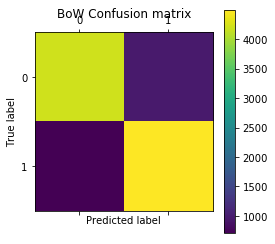

BoW Precision: 0.820906432749
BoW Recall: 0.864178530204


In [4]:
# Import the train/test data (raw image pixels).
with gzip.open('../raw_pixels_dataset_5980.pklz', 'rb') as f:
    (train_labels, train_img, test_labels, test_img) = pickle.load(f)

print("train_img before reshape" + str(train_img.shape))
print("test_img before reshape" + str(test_img.shape))

# -----------------------------------------------------------------
# Extract patches (of 8x8 pixels) from train images and test images

# reshape images to 32x32 and scale values to (0, 1)
train_img = train_img.reshape((-1, 32, 32)).astype('float32') / 255
test_img = test_img.reshape((-1, 32, 32)).astype('float32') / 255

print("train_img shape " + str(train_img.shape))
print("test_img shape " + str(test_img.shape))

# Collect image patches with sliding window (8x8) in each train image sample
PATCH_SIZE = 8
STEP_SIZE = 8

# Create a container for the patches
# 0 = initialization of container   <- This value is going to be updated to the
#                                      number of images of the training set.
# PATCH_SIZE = 8 = x (width) dimensions of the image
# PATCH_SIZE = 8 = y (height) dimensions of the image
# As a result, in this case, the resolution of the patch is 8 x 8 = 64 px
train_patches = np.zeros((0, PATCH_SIZE, PATCH_SIZE))
test_patches = np.zeros((0, PATCH_SIZE, PATCH_SIZE))

# Sliding window process
for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
    for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        train_patches = (
            np.concatenate(  # increase the container each iteration
                (train_patches,
                 train_img[:, x: x + PATCH_SIZE, y: y + PATCH_SIZE]),
                axis=0))
        test_patches = (
            np.concatenate(  # increase the container each iteration
                (test_patches,
                 test_img[:, x: x + PATCH_SIZE, y: y + PATCH_SIZE]),
                axis=0))

# Store the patch as a vector
train_patches = train_patches.reshape((train_patches.shape[0], -1))
test_patches = test_patches.reshape((test_patches.shape[0], -1))
print("train_patches shape " + str(train_patches.shape))
print("test_patches shape " + str(test_patches.shape))

# ---------------------------------------------------
# Preprocessing (I) Contrast Normalization of Patches

mu = train_patches.mean(axis=1)  # mean values

# standard deviation (plus a small value)
sigma = train_patches.std(axis=1) + 0.0001

# subtract the mean and divide by the standard deviation
train_patches = (
    train_patches - mu.reshape([-1, 1])) / (sigma.reshape([-1, 1]))

# Set NaN (not a number) values (if exist) to 0
w = np.isnan(train_patches)
train_patches[w] = 0

# ------------------------------------------------------
# Preprocessing (II) ZCA Whitening of normalized patches

eig_values, eig_vec = np.linalg.eig(np.cov(train_patches.T))
epsilon = 0.01
pca = eig_vec.dot(np.diag((eig_values + epsilon) ** -0.5).dot(eig_vec.T))

M = train_patches.mean(axis=0)
train_patches = train_patches - M  # substract average value
train_patches = np.dot(train_patches, pca)  # perform pca whitening

# ----------------------------------------------------
# K-means clustering to learn K visual_words from data
NUM_VISUAL_WORDS = 32

km = KMeans(n_clusters=NUM_VISUAL_WORDS, max_iter=50, n_init=1, verbose=False)
km.fit(train_patches)

visual_words = km.cluster_centers_
print("visual_words shape " + str(visual_words.shape))

# -------------------------------------------------------------
# Learn a KNN classifier, each visual word represents one class
# In this case KNN is used simply as a way to search the nearest neighbor
# visual word in our vocabulary

neig = KNeighborsClassifier(n_neighbors=1)
neig.fit(visual_words, range(0, NUM_VISUAL_WORDS))

# Extract features from train and test images
train_features = np.zeros((train_img.shape[0], visual_words.shape[0]))
test_features = np.zeros((test_img.shape[0], visual_words.shape[0]))

for i in range(0, train_img.shape[0]):  # for each train image
    # Do sliding window (8x8) in each image to extract patches and build the
    # Bag of Words histogram
    for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
            train_patches = train_img[i, x: x + PATCH_SIZE, y: y + PATCH_SIZE]
            train_patches = train_patches.reshape(1, -1)

            # Preprocessing (I): normalize
            mu = train_patches.mean(axis=1)  # mean values
            sigma = (  # std + small value
                train_patches.std(axis=1) +
                max(np.ptp(train_patches, axis=1) / 20.0, 0.0001))
            train_patches = (
                train_patches-(mu[np.newaxis, :]).T)/(sigma[np.newaxis, :]).T

            # Set NaN values to 0
            w = np.isnan(train_patches)
            train_patches[w] = 0

            # Preprocessing (II): ZCA whitening
            train_patches = train_patches - M  # substract average value
            train_patches = np.dot(train_patches, pca)  # perform pca whitening

            # BoW
            nn = neig.predict(train_patches)
            train_features[i, nn] = train_features[i, nn] + 1

    # Histogram Normalization
    train_features[i, :] = train_features[i, :] / max(train_features[i, :])

for i in range(0, test_img.shape[0]):  # for each test image
    # Do sliding window (8x8) in each image to extract patches and build the
    # Bag of Words histogram
    for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
            test_patches = test_img[i, x: x + PATCH_SIZE, y: y + PATCH_SIZE]
            test_patches = test_patches.reshape(1, -1)

            # PreProcessing (I): Normalize
            mu = test_patches.mean(axis=1)  # mean values
            sigma = (  # std + small value
                test_patches.std(axis=1) +
                max(np.ptp(test_patches, axis=1) / 20.0, 0.0001))
            test_patches = (
                test_patches-(mu[np.newaxis, :]).T) / (sigma[np.newaxis, :]).T

            # Set NaN values to 0
            w = np.isnan(test_patches)
            test_patches[w] = 0

            # PreProcessing (II): ZCA whitening
            test_patches = test_patches - M  # subtract average value
            test_patches = np.dot(test_patches, pca)  # perform pca whitening

            # BoW
            nn = neig.predict(test_patches)
            test_features[i, nn] = test_features[i, nn] + 1

    # Histogram Normalization
    test_features[i, :] = test_features[i, :] / max(test_features[i, :])

# Save your test features
with gzip.open('./BoW-32-8.pklz', 'wb') as f:
    pickle.dump(
        (train_labels, train_features, test_labels, test_features),
        f, pickle.HIGHEST_PROTOCOL)

# Import the train/test data (raw image pixels).
with gzip.open('./BoW-32-8.pklz', 'rb') as f:
    (train_labels, train_images, test_labels, test_images) = pickle.load(f)

print("train_images shape = " + str(train_images.shape))
print("test_images shape = " + str(test_images.shape))

# Logistic Regression gradient descent optimization
w_bow = GradientDescent(train_images, train_labels)

H_bowTr = ([
    classifyVector(train_images[i, :], w_bow, 0.5)
    for i in range(train_images.shape[0])])

# Calculate classification Accuracy in test data
H_bowTe = ([
    classifyVector(test_images[i, :], w_bow, 0.5)
    for i in range(test_images.shape[0])])

# confusion matrix on test data
cm_bow = confusion_matrix(test_labels, H_bowTe)
print 'BoW Confusion matrix:'
print (cm_bow)

print "BoW Train Accuracy:", (str(float(
    np.sum(H_bowTr == train_labels)) / train_labels.shape[0]))
print "BoW Test Accuracy : ", (str(float(
    np.sum(H_bowTe == test_labels)) / test_labels.shape[0]))

# Plot BoW confusion matrix
plt.matshow(cm_bow)
plt.title('BoW Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Unprocessed BoW Precision
bow_precision = float(cm_bow[1, 1]) / float((cm_bow[1, 1] + cm_bow[0, 1]))
print "BoW Precision:", bow_precision

# Unprocessed BoW Recall
bow_recall = float(cm_bow[1, 1]) / float((cm_bow[1, 0] + cm_bow[1, 1]))
print "BoW Recall:", bow_recall

Using the same procedure all the datasets were created, the only value that is changed is the number of visual words and the step size.

train_images shape = (11960L, 64L)
test_images shape = (10396L, 64L)
BoW Confusion matrix:
[[4246  952]
 [ 687 4511]]
BoW Train Accuracy: 0.868227424749
BoW Test Accuracy :  0.842343208927


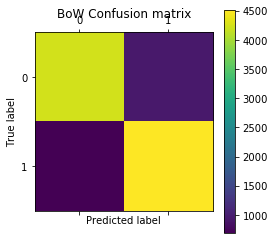

BoW Precision: 0.825736774666
BoW Recall: 0.867833782224


In [5]:
# Import the train/test data (raw image pixels).
with gzip.open('./BoW-64-8.pklz', 'rb') as f:
    (train_labels, train_images, test_labels, test_images) = pickle.load(f)

print("train_images shape = " + str(train_images.shape))
print("test_images shape = " + str(test_images.shape))

# Logistic Regression gradient descent optimization
w_bow = GradientDescent(train_images, train_labels)

H_bowTr = ([
    classifyVector(train_images[i, :], w_bow, 0.5)
    for i in range(train_images.shape[0])])

# Calculate classification Accuracy in test data
H_bowTe = ([
    classifyVector(test_images[i, :], w_bow, 0.5)
    for i in range(test_images.shape[0])])

# confusion matrix on test data
cm_bow = confusion_matrix(test_labels, H_bowTe)
print 'BoW Confusion matrix:'
print (cm_bow)

print "BoW Train Accuracy:", (str(float(
    np.sum(H_bowTr == train_labels)) / train_labels.shape[0]))
print "BoW Test Accuracy : ", (str(float(
    np.sum(H_bowTe == test_labels)) / test_labels.shape[0]))

# Plot BoW confusion matrix
plt.matshow(cm_bow)
plt.title('BoW Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Unprocessed BoW Precision
bow_precision = float(cm_bow[1, 1]) / float((cm_bow[1, 1] + cm_bow[0, 1]))
print "BoW Precision:", bow_precision

# Unprocessed BoW Recall
bow_recall = float(cm_bow[1, 1]) / float((cm_bow[1, 0] + cm_bow[1, 1]))
print "BoW Recall:", bow_recall

train_images shape = (11960L, 64L)
test_images shape = (10396L, 64L)
BoW Confusion matrix:
[[4434  764]
 [ 551 4647]]
BoW Train Accuracy: 0.891722408027
BoW Test Accuracy :  0.873509041939


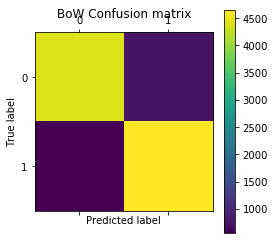

BoW Precision: 0.85880613565
BoW Recall: 0.89399769142


In [6]:
# Import the train/test data (raw image pixels).
with gzip.open('./BoW-64-4.pklz', 'rb') as f:
    (train_labels, train_images, test_labels, test_images) = pickle.load(f)

print("train_images shape = " + str(train_images.shape))
print("test_images shape = " + str(test_images.shape))

# Logistic Regression gradient descent optimization
w_bow = GradientDescent(train_images, train_labels)

H_bowTr = ([
    classifyVector(train_images[i, :], w_bow, 0.5)
    for i in range(train_images.shape[0])])

# Calculate classification Accuracy in test data
H_bowTe = ([
    classifyVector(test_images[i, :], w_bow, 0.5)
    for i in range(test_images.shape[0])])

# confusion matrix on test data
cm_bow = confusion_matrix(test_labels, H_bowTe)
print 'BoW Confusion matrix:'
print (cm_bow)

print "BoW Train Accuracy:", (str(float(
    np.sum(H_bowTr == train_labels)) / train_labels.shape[0]))
print "BoW Test Accuracy : ", (str(float(
    np.sum(H_bowTe == test_labels)) / test_labels.shape[0]))

# Plot BoW confusion matrix
plt.matshow(cm_bow)
plt.title('BoW Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Unprocessed BoW Precision
bow_precision = float(cm_bow[1, 1]) / float((cm_bow[1, 1] + cm_bow[0, 1]))
print "BoW Precision:", bow_precision

# Unprocessed BoW Recall
bow_recall = float(cm_bow[1, 1]) / float((cm_bow[1, 0] + cm_bow[1, 1]))
print "BoW Recall:", bow_recall

train_images shape = (11960L, 128L)
test_images shape = (10396L, 128L)
BoW Confusion matrix:
[[4348  850]
 [ 608 4590]]
BoW Train Accuracy: 0.876003344482
BoW Test Accuracy :  0.859753751443


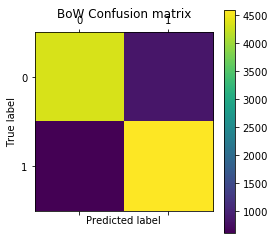

BoW Precision: 0.84375
BoW Recall: 0.88303193536


In [3]:
# Import the train/test data (raw image pixels).
with gzip.open('./BoW-128-8.pklz', 'rb') as f:
    (train_labels, train_images, test_labels, test_images) = pickle.load(f)

print("train_images shape = " + str(train_images.shape))
print("test_images shape = " + str(test_images.shape))

# Logistic Regression gradient descent optimization
w_bow = GradientDescent(train_images, train_labels)

H_bowTr = ([
    classifyVector(train_images[i, :], w_bow, 0.5)
    for i in range(train_images.shape[0])])

# Calculate classification Accuracy in test data
H_bowTe = ([
    classifyVector(test_images[i, :], w_bow, 0.5)
    for i in range(test_images.shape[0])])

# confusion matrix on test data
cm_bow = confusion_matrix(test_labels, H_bowTe)
print 'BoW Confusion matrix:'
print (cm_bow)

print "BoW Train Accuracy:", (str(float(
    np.sum(H_bowTr == train_labels)) / train_labels.shape[0]))
print "BoW Test Accuracy : ", (str(float(
    np.sum(H_bowTe == test_labels)) / test_labels.shape[0]))

# Plot BoW confusion matrix
plt.matshow(cm_bow)
plt.title('BoW Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Unprocessed BoW Precision
bow_precision = float(cm_bow[1, 1]) / float((cm_bow[1, 1] + cm_bow[0, 1]))
print "BoW Precision:", bow_precision

# Unprocessed BoW Recall
bow_recall = float(cm_bow[1, 1]) / float((cm_bow[1, 0] + cm_bow[1, 1]))
print "BoW Recall:", bow_recall

train_images shape = (11960L, 128L)
test_images shape = (10396L, 128L)
BoW Confusion matrix:
[[4542  656]
 [ 485 4713]]
BoW Train Accuracy: 0.90643812709
BoW Test Accuracy :  0.890246248557


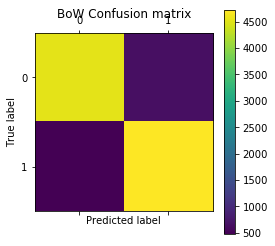

BoW Precision: 0.877817098156
BoW Recall: 0.906694882647


In [4]:
# Import the train/test data (raw image pixels).
with gzip.open('./BoW-128-4.pklz', 'rb') as f:
    (train_labels, train_images, test_labels, test_images) = pickle.load(f)

print("train_images shape = " + str(train_images.shape))
print("test_images shape = " + str(test_images.shape))

# Logistic Regression gradient descent optimization
w_bow = GradientDescent(train_images, train_labels)

H_bowTr = ([
    classifyVector(train_images[i, :], w_bow, 0.5)
    for i in range(train_images.shape[0])])

# Calculate classification Accuracy in test data
H_bowTe = ([
    classifyVector(test_images[i, :], w_bow, 0.5)
    for i in range(test_images.shape[0])])

# confusion matrix on test data
cm_bow = confusion_matrix(test_labels, H_bowTe)
print 'BoW Confusion matrix:'
print (cm_bow)

print "BoW Train Accuracy:", (str(float(
    np.sum(H_bowTr == train_labels)) / train_labels.shape[0]))
print "BoW Test Accuracy : ", (str(float(
    np.sum(H_bowTe == test_labels)) / test_labels.shape[0]))

# Plot BoW confusion matrix
plt.matshow(cm_bow)
plt.title('BoW Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Unprocessed BoW Precision
bow_precision = float(cm_bow[1, 1]) / float((cm_bow[1, 1] + cm_bow[0, 1]))
print "BoW Precision:", bow_precision

# Unprocessed BoW Recall
bow_recall = float(cm_bow[1, 1]) / float((cm_bow[1, 0] + cm_bow[1, 1]))
print "BoW Recall:", bow_recall

<font color='blue'>Train and test your classifier by modifying the number of patches extracted from each image. This is, modify the STEP_SIZE parameter to make patch extraction more dense. How it does affect on the classifier's Accuracy? Are the vocabulary size and patch density parameters related?</font>

<table>
    <tr>
        <td> Num. Visual Words </td>
        <td> Step Size </td>
        <td> Test Accuracy </td>
    </tr>
    <tr>
        <td> 32 </td>
        <td> 8 </td>
        <td> 83.78 % </td>
    </tr>
    
    <tr>
        <td> 64 </td>
        <td> 8 </td>
        <td> 84.23 % </td>
    </tr>
    
    <tr>
        <td> 64 </td>
        <td> 4 </td>
        <td> 87.35 % </td>
    </tr>
    
    <tr>
        <td> 128 </td>
        <td> 8 </td>
        <td> 85.97 % </td>
    </tr>
    
    <tr>
        <td> 128 </td>
        <td> 4 </td>
        <td> 89.02 % </td>
    </tr>
</table>

<font color='blue'>Train and test your classifier using different sizes for the vocabulary (NUM_VISUAL_WORDS). Make a plot of Test Accuracy as a function of the vocabulary size.</font>

8 BoW Test Accuracy :  0.764813389765
16 BoW Test Accuracy :  0.823201231243
32 BoW Test Accuracy :  0.837822239323
64 BoW Test Accuracy :  0.842343208927
128 BoW Test Accuracy :  0.859753751443
256 BoW Test Accuracy :  0.860523278184


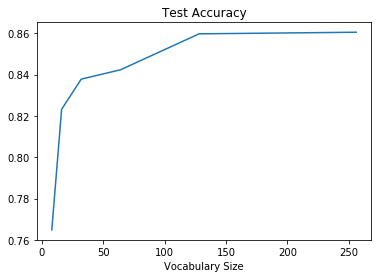

In [6]:
# Variables initialization
step_size = 8
X = np.zeros(0)
Y = np.zeros(0)


# Create a varying vocabulary size
while step_size <= 256:
    # Data creation
    X = np.append(X, step_size)
    # Import the train/test data (raw image pixels).
    with gzip.open('./BoW-' + str(step_size) + '-8.pklz', 'rb') as f:
        (train_labels, train_images, test_labels, test_images) = pickle.load(f)

    # Logistic Regression gradient descent optimization
    w_bow = GradientDescent(train_images, train_labels)

    H_bowTr = ([
        classifyVector(train_images[i, :], w_bow, 0.5)
        for i in range(train_images.shape[0])])

    # Calculate classification Accuracy in test data
    H_bowTe = ([
        classifyVector(test_images[i, :], w_bow, 0.5)
        for i in range(test_images.shape[0])])

    accuracy = (str(
        float(np.sum(H_bowTe == test_labels)) / test_labels.shape[0]))

    Y = np.append(Y, accuracy)
    print step_size, "BoW Test Accuracy : ", accuracy

    # increase step size and counter
    step_size = step_size * 2  # Powers of two

# Plot the Test Accuracy (y) as a function [y = f(x)] of  the vocabulary
# size (x).
plt.plot(X, Y)
plt.title('Test Accuracy')
plt.xlabel('Vocabulary Size')
plt.show()

## <font color='red'>Exercise 3: K-NN Classifier.</font>

Train a K-NN classifier for text/non-text classification using the learned BoW representations.

Compare the Accuracy using different values of K for the K-NN classifier with the Accuracy of the Logistic Regression classifier. Comment the advantages/disadvantages of each classifier.

<table>
    <tr>
        <td> Method </td>
        <td> Test Accuracy </td>
        <td> Precision </td>
        <td> Recall </td>
    </tr>
    <tr>
        <td colspan=2></td>
    </tr>
    
    <tr>
        <td> K-NN (K=3) </td>
        <td> - </td>
        <td> - </td>
        <td> - </td>
    </tr>
    
    <tr>
        <td> K-NN (K=7) </td>
        <td> - </td>
        <td> - </td>
        <td> - </td>
    </tr>
    
    <tr>
        <td> Logistic Regression Classifier </td>
        <td> - </td>
        <td> - </td>
        <td> - </td>
    </tr>
</table>

## <font color='red'>Exercise 4: Open Exercise (optional)</font>

Propose and implement an improvement, or an extra evaluation analysis, for our Text vs. Non-text classifier in its current status.

Some ideas (not a closed list):

* Compare the performance of BoW using hard assignment (each patch counts 1 only to the bin of its nearest visual Word) and soft assignment (each patch counts "d" to the K bins of its K-NNs, where "d" is proportional to the NN distance).

* Improve the BoW representation by using spatial information (Spatial Pyramids).

* Evaluate the Test Accuracy as a function of of patch size.

* Evaluate the Test Accuracy as a function of the number of training examples ($m$).

* Use cross-validation to tune the meta-parameters (vocabulary size, patch_size) of BoW. 

* Compare ZCA and PCA whitening.

* Implement the Stochastic Gradient Descent algorithm. Show how it improves the training time performance.
